<a href="https://colab.research.google.com/github/WIVIV/Project_3_AFI/blob/master/Proj_3_WF_GRID_TL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install -q pyyaml h5py 

In [2]:
#Mount your Google Drive on your runtime using an authorization code.
#Note this only supports reading, writing, and moving files; to programmatically modify sharing settings or other metadata, use one of the other options below.
#instructions here https://colab.research.google.com/notebooks/io.ipynb#

from google.colab import drive, files
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


**Use TensorFlow V2.x**

In [3]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

# Load the TensorBoard notebook extension
%load_ext tensorboard
!rm -rf ./logs/ 

TensorFlow 2.x selected.


Imports

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals
from tensorflow.keras.models import Sequential

from tensorflow.keras import models
from tensorflow.keras import layers

from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import datetime

Test GPU available

In [5]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


Import images from DropBox

In [6]:
!wget "https://www.dropbox.com/s/rl0qbub4clah2w9/grid_version.tar"


--2020-02-15 00:40:45--  https://www.dropbox.com/s/rl0qbub4clah2w9/grid_version.tar
Resolving www.dropbox.com (www.dropbox.com)... 162.125.8.1, 2620:100:601b:1::a27d:801
Connecting to www.dropbox.com (www.dropbox.com)|162.125.8.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/rl0qbub4clah2w9/grid_version.tar [following]
--2020-02-15 00:40:45--  https://www.dropbox.com/s/raw/rl0qbub4clah2w9/grid_version.tar
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc311a3a055b6fa0da0e94df7b3e.dl.dropboxusercontent.com/cd/0/inline/AyHNGhjqV8hq9vqiPuERktoYf7OgXw5dLIY1fKgNNRvqlk1K5ZzO6Klmhni-Ag0daKzqwdR49_fasvgNruvexCAkBN1TMxDYQ_g5B6pM-6szypjsHadwq3TJPNGUOclhMXI/file# [following]
--2020-02-15 00:40:45--  https://uc311a3a055b6fa0da0e94df7b3e.dl.dropboxusercontent.com/cd/0/inline/AyHNGhjqV8hq9vqiPuERktoYf7OgXw5dLIY1fKgNNRvqlk1K5ZzO6Klmhni-Ag0daKzqwdR49_fasvgNruvexCAkBN1TMxDYQ_g5B6

Inspect Image Archive File

In [7]:
!tar -xvf 'grid_version.tar'

Streaming output truncated to the last 5000 lines.
grid_version/train/grid_no_smoke/1498418433_+02040_06_05.png
grid_version/train/grid_no_smoke/1498418373_+01980_08_09.png
grid_version/train/grid_no_smoke/1498418493_+02100_05_06.png
grid_version/train/grid_no_smoke/1498417893_+01500_02_06.png
grid_version/train/grid_no_smoke/1498418253_+01860_04_07.png
grid_version/train/grid_no_smoke/1498418013_+01620_09_06.png
grid_version/train/grid_no_smoke/1498416993_+00600_04_08.png
grid_version/train/grid_no_smoke/1498416993_+00600_03_01.png
grid_version/train/grid_no_smoke/1498417233_+00840_02_01.png
grid_version/train/grid_no_smoke/1498416693_+00300_08_07.png
grid_version/train/grid_no_smoke/1498416693_+00300_06_02.png
grid_version/train/grid_no_smoke/1498418013_+01620_07_03.png
grid_version/train/grid_no_smoke/1498418373_+01980_01_05.png
grid_version/train/grid_no_smoke/1498417533_+01140_03_05.png
grid_version/train/grid_no_smoke/1498416753_+00360_03_04.png
grid_version/train/grid_no_smoke/1

Split data into train and vaildate

In [0]:
train_image_folder ='grid_version/train'
validate_image_folder = 'grid_version/validate'

In [0]:
train_smoke_dir = 'grid_version/train/grid_smoke'  # directory with our training smoke pictures
train_nosmoke_dir = 'grid_version/train/grid_no_smoke'  # directory with our training no smoke pictures
validation_smoke_dir = 'grid_version/validate/grid_smoke' # directory with our validation smoke pictures
validation_nosmoke_dir = 'grid_version/validate/grid_no_smoke' # directory with our validation no smoke pictures


NUmber of images in each subset

In [0]:
num_smoke_tr = len(os.listdir(train_smoke_dir))
num_nosmoke_tr = len(os.listdir(train_nosmoke_dir))

num_smoke_val = len(os.listdir(validation_smoke_dir))
num_nosmoke_val = len(os.listdir(validation_nosmoke_dir))

total_train = num_smoke_tr + num_nosmoke_tr
total_val = num_smoke_val + num_nosmoke_val

In [11]:
print('total training smoke images:', num_smoke_tr)
print('total training nosmoke images:', num_nosmoke_tr)

print('total validation smoke images:', num_smoke_val)
print('total validation nosomke images:', num_nosmoke_val)
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)

Distribution = {
'Total training images': total_train,
'Total validation images': total_val,
'total training smoke images': num_smoke_tr,
'total training nosmoke images': num_nosmoke_tr,
'total validation smoke images': num_smoke_val,
'total validation nosomke images': num_nosmoke_val
}

total training smoke images: 999
total training nosmoke images: 2622
total validation smoke images: 999
total validation nosomke images: 2622
--
Total training images: 3621
Total validation images: 3621


<Figure size 432x288 with 0 Axes>

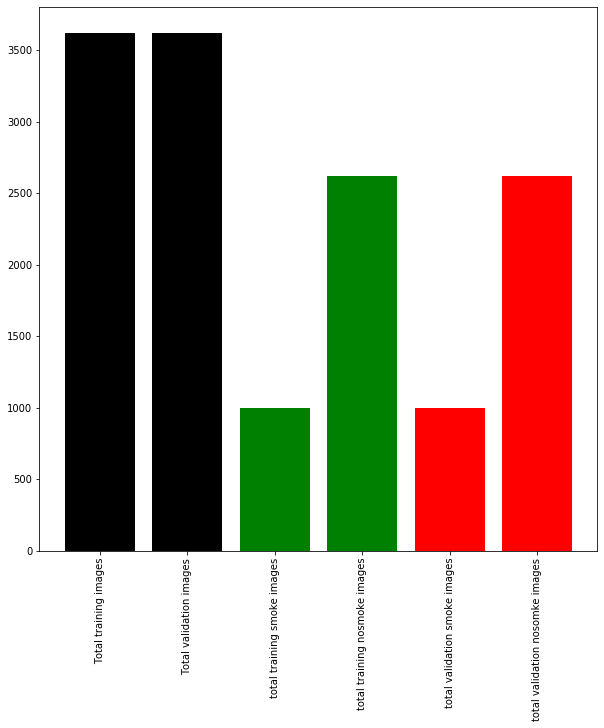

In [12]:
fig_distribution = plt.figure()
plt.figure(figsize=(10, 10))
plt.bar(range(len(Distribution)), list(Distribution.values()), align='center',color=['black', 'black', 'green', 'green', 'red','red'])
plt.xticks(range(len(Distribution)), list(Distribution.keys()),rotation=90)
fig_distribution.show()
#plt.savefig("fig_distribution.png")
#files.download("fig_distribution.png") 

**Create data generator**

In [0]:
#Augment the images. Note best results were gained with limited preprocessing
train_image_generator = ImageDataGenerator(rescale=1./255,
                                            ##Have tried different combintions and values of these settings
                                            #rotation_range=40,
                                            #width_shift_range=0.2,
                                            #height_shift_range=0.2,
                                            #brightness_range=[0.3,-2],
                                            #shear_range=0.2,
                                            #zoom_range=0.2,
                                            #horizontal_flip=True,
                                            #fill_mode='nearest')
)
validation_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our validation data

Set Paramaters

In [0]:
batch_size = 30
IMG_HEIGHT = 224
IMG_WIDTH = 224
class_mode='binary'


Create train and validate data generators

In [15]:
#using Keras ImageDataGenerator to perform image augmentation and flow_from_directory to take the path to the directory & generates batches of augmented data.
train_data_gen = train_image_generator.flow_from_directory(train_image_folder,
                                                           batch_size=batch_size,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode=class_mode)

Found 3621 images belonging to 2 classes.


In [16]:
val_data_gen = validation_image_generator.flow_from_directory(validate_image_folder,
                                                              batch_size=batch_size,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode=class_mode)

Found 3621 images belonging to 2 classes.


Print sample images

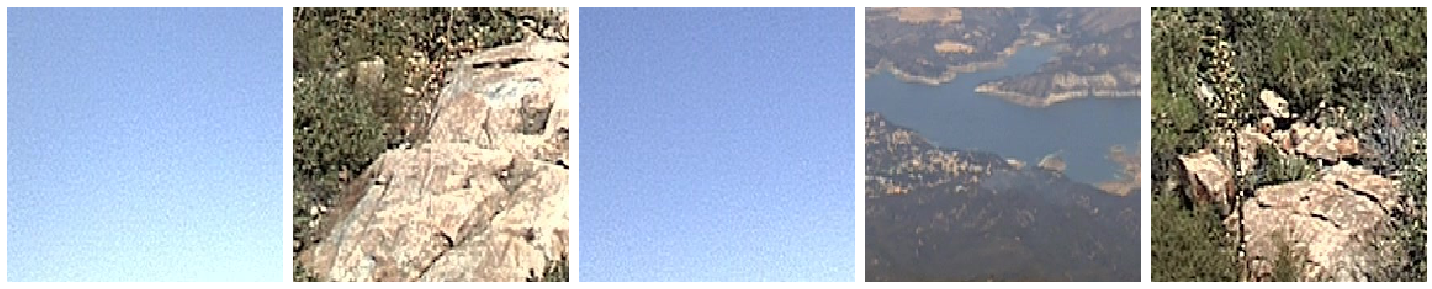

In [17]:
sample_training_images, _ = next(train_data_gen)
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()
  
plotImages(sample_training_images[:5])

Create Custom Built Model

In [18]:
#3 conv layers with relu activation and binary crossentropy for loss.
model = Sequential([
    Conv2D(16, (3,3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(2,2),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
])


from tensorflow.keras.optimizers import RMSprop, Adam
model.compile(optimizer=RMSprop(lr=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 26, 26, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 43264)             0

Create logs for TensorBoard

In [0]:
logdir = os.path.join("tf_logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

In [20]:
#Setting 15 epochs for customer model and then adding epocs for transfer learning and fine turning to allow for data to captured for the complete set and plot the resutls to compare. 
initial_epochs = 15

history = model.fit(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=initial_epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size,
    verbose=1,
    callbacks=[tensorboard_callback]
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 120 steps, validate for 120 steps
Epoch 1/15
120/120 [==============================] - 26s 219ms/step - loss: 0.8118 - accuracy: 0.7875 - val_loss: 0.2200 - val_accuracy: 0.9361
Epoch 2/15
120/120 [==============================] - 24s 200ms/step - loss: 0.3448 - accuracy: 0.8914 - val_loss: 0.1431 - val_accuracy: 0.9606
Epoch 3/15
120/120 [==============================] - 24s 197ms/step - loss: 0.2103 - accuracy: 0.9298 - val_loss: 0.1172 - val_accuracy: 0.9622
Epoch 4/15
120/120 [==============================] - 24s 199ms/step - loss: 0.1712 - accuracy: 0.9471 - val_loss: 0.0848 - val_accuracy: 0.9600
Epoch 5/15
120/120 [==============================] - 23s 195ms/step - loss: 0.1277 - accuracy: 0.9557 - val_loss: 0.1066 - val_accuracy: 0.9464
Epoch 6/15
120/120 [==============================] - 23s 195ms/step - loss: 0.1048 - accuracy: 0.9627 - val_loss: 0.5897 - val_accuracy: 0.7756
Epoch 7/15
120/120 [================

In [0]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Plot results

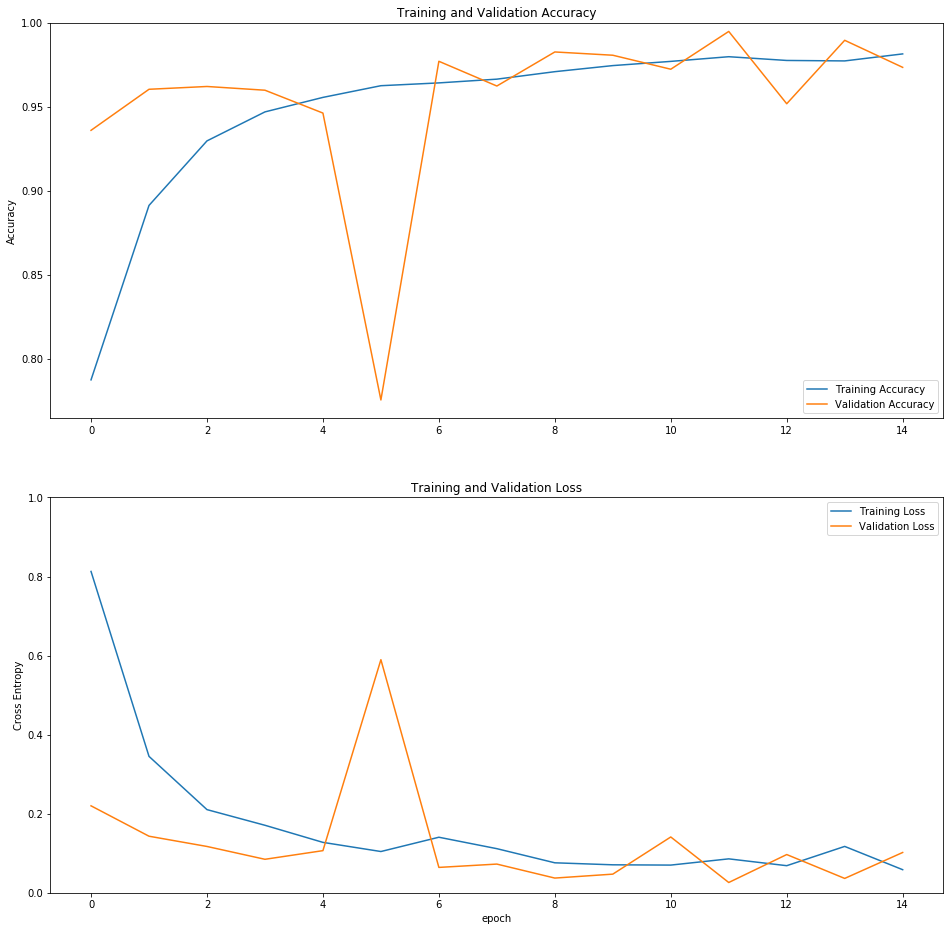

In [22]:
fig_base_model = plt.figure(figsize=(16, 16))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
fig_base_model.show()
#plt.savefig("fig_base_model.png")
#files.download("fig_base_model.png") 

In [0]:
#save model to google dirve
#model_save_name = 'custom_model.h5'
#path = F"/content/gdrive/My Drive/{model_save_name}" 
#model.save(path)

**Transfer Learning**

In [24]:
#Tranfser Learning using models that are composed of two parts, a convolutional base and a classifier.
#using VGG19 model with imagenet weights
from keras.applications import VGG19

#create a base model
base_model = tf.keras.applications.VGG19(input_shape=(IMG_HEIGHT, IMG_WIDTH,3), include_top=False,weights='imagenet')#image net weights removed

Using TensorFlow backend.


In [25]:
batch_size=30
class_mode = 'binary'
total_classes = 1
activation_function = 'sigmoid'
loss_function = 'binary_crossentropy'


#Augment the images. Note best results were gained with limited preprocessing
train_image_generator = tf.keras.preprocessing.image.ImageDataGenerator(
            preprocessing_function=tf.keras.applications.vgg19.preprocess_input,
            rescale=1.0/255.0,
            #shear_range=0.2, 
            #zoom_range=[0.9, 1.25],
            #brightness_range=[0.5, 1.5],
            horizontal_flip=True,
            vertical_flip=True
            )

#using Keras ImageDataGenerator to perform image augmentation and flow_from_directory to take the path to the directory & generates batches of augmented data.     
validation_image_generator = tf.keras.preprocessing.image.ImageDataGenerator(
            preprocessing_function=tf.keras.applications.vgg19.preprocess_input,
            rescale=1.0/255.0)


train_generator = train_image_generator.flow_from_directory(
            train_image_folder,
            target_size=(IMG_HEIGHT, IMG_WIDTH),
            batch_size=batch_size,
            class_mode=class_mode)

validation_generator = validation_image_generator.flow_from_directory(
            validate_image_folder,
            target_size=(IMG_HEIGHT, IMG_WIDTH),
            batch_size=batch_size,
            class_mode=class_mode)




Found 3621 images belonging to 2 classes.
Found 3621 images belonging to 2 classes.


In [26]:
#combining VGG19 with pooling layer and predictio layer
reload_checkpoint=True
img_input = layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))
global_average_layer = layers.GlobalAveragePooling2D()
prediction_layer = layers.Dense(total_classes, activation=activation_function)

model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])


print("Number of layers in the base model: ", len(base_model.layers))

base_model.trainable = False

model.compile(optimizer=Adam(lr=0.0005),
              loss=loss_function,
              metrics=['accuracy'])

model.summary()

Number of layers in the base model:  22
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 7, 7, 512)         20024384  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 513       
Total params: 20,024,897
Trainable params: 513
Non-trainable params: 20,024,384
_________________________________________________________________


In [27]:
#run TL for 15 epochs
tl_epochs = 15
steps_per_epoch = train_generator.n // train_generator.batch_size
validation_steps = validation_generator.n // validation_generator.batch_size

history_tl = model.fit(
      train_generator,
      steps_per_epoch=steps_per_epoch,
      validation_data=validation_generator,
      validation_steps=validation_steps,
      callbacks=[tensorboard_callback],
      epochs=tl_epochs,
      #initial_epoch=history.epoch[-1],
      verbose=1,)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 120 steps, validate for 120 steps
Epoch 1/15
120/120 [==============================] - 55s 456ms/step - loss: 0.5559 - accuracy: 0.7238 - val_loss: 0.5237 - val_accuracy: 0.7244
Epoch 2/15
120/120 [==============================] - 52s 437ms/step - loss: 0.5075 - accuracy: 0.7238 - val_loss: 0.4871 - val_accuracy: 0.7244
Epoch 3/15
120/120 [==============================] - 53s 445ms/step - loss: 0.4763 - accuracy: 0.7265 - val_loss: 0.4604 - val_accuracy: 0.7339
Epoch 4/15
120/120 [==============================] - 54s 447ms/step - loss: 0.4504 - accuracy: 0.7416 - val_loss: 0.4383 - val_accuracy: 0.7536
Epoch 5/15
120/120 [==============================] - 54s 449ms/step - loss: 0.4293 - accuracy: 0.7639 - val_loss: 0.4197 - val_accuracy: 0.7558
Epoch 6/15
120/120 [==============================] - 54s 448ms/step - loss: 0.4099 - accuracy: 0.7939 - val_loss: 0.4038 - val_accuracy: 0.7692
Epoch 7/15
120/120 [================

In [0]:
#add results from TL model to prior results
acc = history_tl.history['accuracy']
val_acc = history_tl.history['val_accuracy']

loss = history_tl.history['loss']
val_loss = history_tl.history['val_loss']

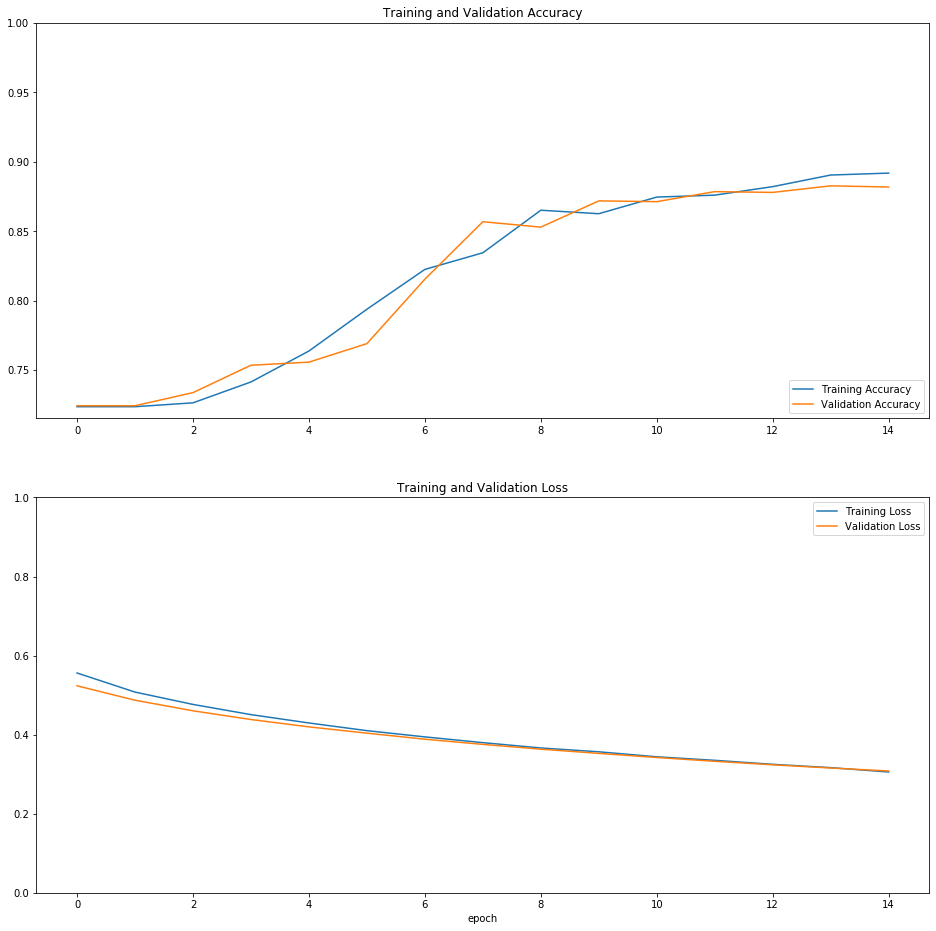

In [29]:
#plot results with line denoting the spilt between models
fig_tl_model = plt.figure(figsize=(16, 16))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([min(plt.ylim()),1])
#plt.plot([initial_epochs,initial_epochs],
#          plt.ylim(), label='Start Transfer Learing')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
#plt.plot([initial_epochs,initial_epochs],
#         plt.ylim(), label='Start Transfer Learing')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
fig_tl_model.show()
#plt.savefig("fig_tl_model.png")
#files.download("fig_tl_model.png") 

In [0]:
#model.save('tl_model.h5')
#files.download('tl_model.h5')

**Fine Tuning**

In [31]:
#Fine-tune a subset of top layers
base_model.trainable = True

print("Number of layers in the base model: ", len(base_model.layers))

# Fine tune start from layer 19
fine_tune_at = 19

# Freeze layers before fine tuning layer
for layer in base_model.layers[:fine_tune_at]:
     layer.trainable = False

model.compile(optimizer=Adam(lr=0.0005),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Number of layers in the base model:  22
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 7, 7, 512)         20024384  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 513       
Total params: 20,024,897
Trainable params: 4,720,129
Non-trainable params: 15,304,768
_________________________________________________________________


In [32]:
fine_tune_epochs = 15
total_epochs = tl_epochs + fine_tune_epochs

steps_per_epoch = train_generator.n // train_generator.batch_size
validation_steps = validation_generator.n // validation_generator.batch_size

history_fine = model.fit(
      train_generator,
      steps_per_epoch=steps_per_epoch,
      validation_data=validation_generator,
      validation_steps=validation_steps,
      callbacks=[tensorboard_callback],
      epochs=total_epochs,
      initial_epoch=history_tl.epoch[-1],
      verbose=1,)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 120 steps, validate for 120 steps
Epoch 15/30
120/120 [==============================] - 57s 471ms/step - loss: 0.1975 - accuracy: 0.9254 - val_loss: 0.1016 - val_accuracy: 0.9747
Epoch 16/30
120/120 [==============================] - 55s 462ms/step - loss: 0.0742 - accuracy: 0.9797 - val_loss: 0.0619 - val_accuracy: 0.9811
Epoch 17/30
120/120 [==============================] - 56s 464ms/step - loss: 0.0747 - accuracy: 0.9794 - val_loss: 0.0523 - val_accuracy: 0.9819
Epoch 18/30
120/120 [==============================] - 55s 462ms/step - loss: 0.0613 - accuracy: 0.9808 - val_loss: 0.0437 - val_accuracy: 0.9833
Epoch 19/30
120/120 [==============================] - 55s 462ms/step - loss: 0.0585 - accuracy: 0.9830 - val_loss: 0.0474 - val_accuracy: 0.9825
Epoch 20/30
120/120 [==============================] - 55s 462ms/step - loss: 0.0518 - accuracy: 0.9836 - val_loss: 0.0540 - val_accuracy: 0.9900
Epoch 21/30
120/120 [=========

In [0]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

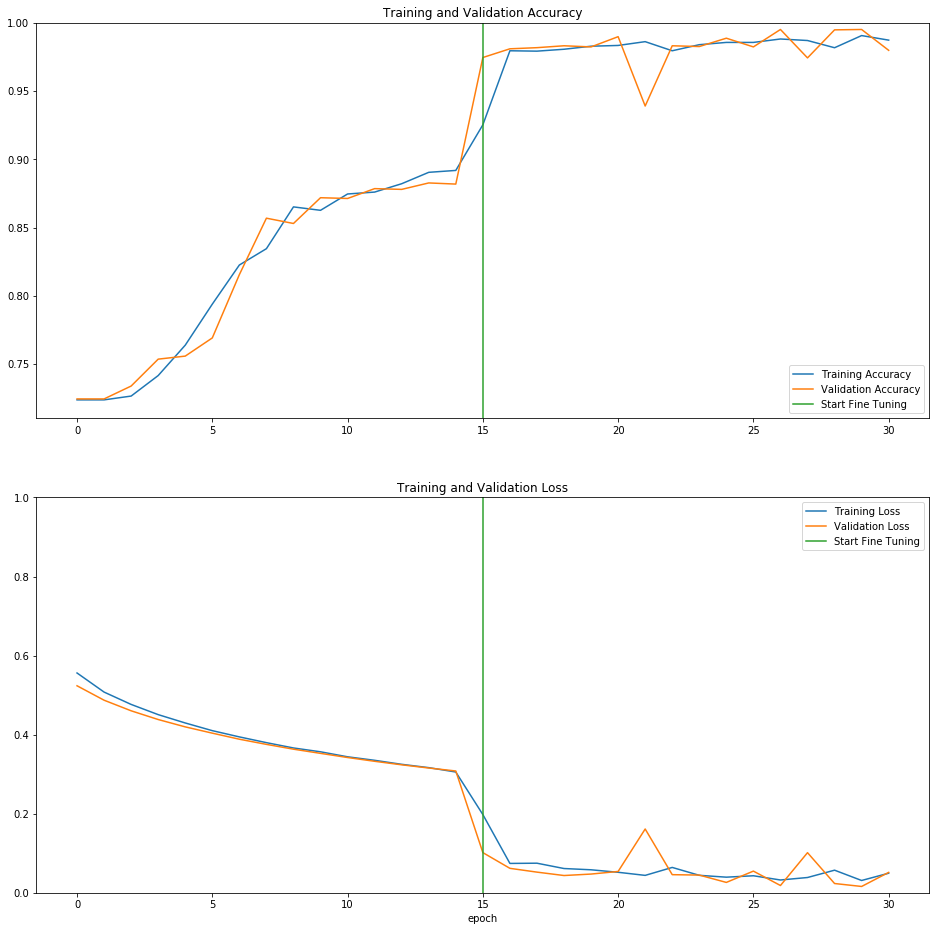

In [35]:
fig_ft_model = plt.figure(figsize=(16, 16))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([min(plt.ylim()),1])
#plt.plot([initial_epochs,initial_epochs],
#          plt.ylim(), label='Start Transfer Learing')
plt.plot([tl_epochs,tl_epochs],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
#plt.plot([initial_epochs,initial_epochs],
#          plt.ylim(), label='Start Transfer Learing')
plt.plot([tl_epochs,tl_epochs],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
fig_ft_model.show()
#plt.savefig("fig_ft_model.png")
#files.download("fig_ft_model.png") 

In [0]:
#save model to google dirve
ft_model_save_name = 'ft_model.h5'
path = F"/content/gdrive/My Drive/{ft_model_save_name}" 
model.save(path)

BREAK